In [2]:
import networkx as nx
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 

In [3]:
## tqdm overflow issues

# from tqdm.notebook import tqdm

# #usual installation 
# pip install ipywidgets 
# jupyter nbextension enable --py widgetsnbextension
# #you are my saver!
# jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [4]:
#################################################################################
############################### Helper Functions  ###############################
#################################################################################

def set_influence(G, value, node=None):
    '''
        Set influence of a node in a network G or
        set influence of all nodes to value.
        G      ::  a networkx graph
        node   ::  a reference to a node in G
        value  ::  an integer 0 or 1
    '''
    if node:
        G.nodes[node][label] = value
    else:
        influence_attrib = { i : value for i in range(N) }
        nx.set_node_attributes(G,influence_attrib, label)
        
def get_is_influenced(G, node):
    return G.nodes[node][label]
        
def get_number_influenced(G):
    '''
        Get the number of influenced nodes.
    '''
    return sum(nx.get_node_attributes(G, label).values())

def check_can_influence(G, node, q):
    '''
        Determines whether a node is influenced by
        its neighbours. (Threshold Check)
    '''
    if get_is_influenced(G, node) == 1:
        return False
    
    friends = list(G.neighbors(node))
    num_friends = len(friends)
    
    if num_friends == 0:
        return False
    
    num_influenced = sum([1 for friend in friends if G.nodes[friend][label] == 1])
    
    if num_influenced/num_friends > q:
        return True
    return False

In [5]:
#################################################################################
########################## Simulation Helper Functions ##########################
#################################################################################

def spread_influence(G, current_node, phi):
    '''
        Recursive function to spread influence 
        from current_node in G.
    '''
    
    ## Not interesting
    if get_is_influenced(G, current_node) == 0 and not check_can_influence(G, current_node, phi):
        return
    else:
        set_influence(G, 1, current_node)
        ## Find uninfluenced friends
        friends = list(G.neighbors(current_node))
        targets = [friend for friend in friends if G.nodes[friend][label] == 0]
        
        for friend in targets:
            spread_influence(G, friend, phi)
        
def get_vulnerable(G, phi):
    '''
        Check for vulnerable nodes.
        Return list of vulnerable nodes.
    '''
    vulnerable = []
    for node in G.nodes():
        if check_can_influence(G, node, phi):
            vulnerable.append(node)
    return vulnerable
        
def simulate_spread(G, nodes, phi):
    '''
        Simulates the spread of influence starting from each 
        node in nodes and returns a list containing the 
        number of influenced from starting at each node.
    '''
    S = []
    for node in nodes:
        G_tmp = G.copy()
        set_influence(G_tmp, 1, node)
        spread_influence(G_tmp, node, phi)
        
        vulnerable = get_vulnerable(G_tmp, phi)

        while len(vulnerable) != 0:
            for vul in vulnerable:
                spread_influence(G_tmp, vul, phi)
            vulnerable = get_vulnerable(G_tmp, phi)

        S.append(get_number_influenced(G_tmp))
        
    return S


In [6]:
#################################################################################
######################## Simulation Setup and Parameters ########################
#################################################################################

label = 'is_influenced'
## Top q% of influence (degree) distribution are classified as influential
q = 0.1   
## Threshold 
phi = 0.18

In [ ]:
'''
    Test Run
'''
## Random Graph and Parameters
N = 100
p = 0.0015
G = nx.erdos_renyi_graph(N, p, seed=2020)

G_tmp = G.copy()
## Setup influence attribute
set_influence(G, 0)
## Retrieve influential nodes - top q% and non-influential nodes
degree_ordered_nodes = sorted(list(G.nodes()), key=lambda x: G.degree(x), reverse=True)
influential_nodes = degree_ordered_nodes[:int(q*N)]
normie_nodes = degree_ordered_nodes[int(q*N):]
## Compute Results
S_influenced = simulate_spread(G, influential_nodes, phi)
S_normie = simulate_spread(G, normie_nodes, phi)

In [33]:
%%time
#################################################################################
################################## Simulation ###################################
#################################################################################

N = 100
q = 0.1   
phi = 0.18
max_n_avg = 7
increment = 0.2
num_simulations = 15
label = 'is_influenced'
directed = False

n_avg = np.arange(1, max_n_avg, increment)
p = [avg/(N-1) for avg in n_avg]
n = len(p)
S_influential, S_normal = np.zeros([num_simulations, n]), np.zeros([num_simulations, n])

for i in tqdm(range(num_simulations)):
    for j in range(n):
        probability = p[j]
        G = nx.erdos_renyi_graph(N, probability)
        set_influence(G, 0)
        ## Retrieve influential nodes - top q% and non-influential nodes
        degree_ordered_nodes = sorted(list(G.nodes()), key=lambda x: G.degree(x), reverse=True)
        influential_nodes = degree_ordered_nodes[:int(q*N)]
        normal_nodes = degree_ordered_nodes[int(q*N):]
        ## Simulation
        influential = simulate_spread(G, influential_nodes, phi)
        normal = simulate_spread(G, normal_nodes, phi)
        ## Store results
        S_influential[i,j] += np.mean(influential)
        S_normal[i,j] += (np.mean(normal))

100%|██████████| 15/15 [01:49<00:00,  7.33s/it]

CPU times: user 1min 22s, sys: 559 ms, total: 1min 23s
Wall time: 1min 49s


In [34]:
##########################
### Processing Results ###
##########################
names = ["Influential", "Normal"]

# Number of Nodes of Network Influenced
N_influential = np.apply_along_axis(np.mean, 0, S_influential)
N_normal = np.apply_along_axis(np.mean, 0, S_normal)

# Proportion of Network Influenced
P_influential = [x/N for x in N_influential]
P_normal = [x/N for x in N_normal]

In [35]:
S_normal.shape

(15, 30)

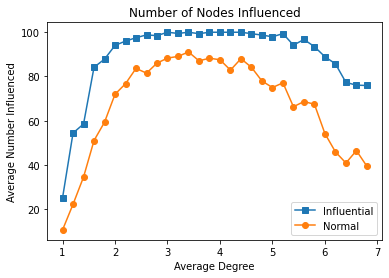

In [36]:
############
### Pots ###
############

plt.plot(n_avg, N_influential, "-s")
plt.plot(n_avg, N_normal, "-o")
plt.ylabel("Average Number Influenced")
plt.xlabel("Average Degree")
plt.title("Number of Nodes Influenced")
plt.legend(names)

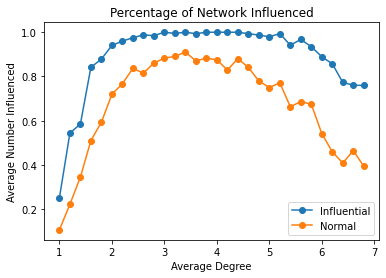

In [37]:
plt.plot(n_avg, P_influential, "-o")
plt.plot(n_avg, P_normal, "-o")
plt.ylabel("Average Number Influenced")
plt.xlabel("Average Degree")
plt.title("Percentage of Network Influenced")
plt.legend(names)

In [ ]:
%store 

In [39]:
backup = pd.HDFStore('Results/N1000q10phi8avg6sim75.h5')

backup['n_avg'] = pd.Series(n_avg)

backup['S_Normal'] = pd.DataFrame(S_normal)
backup['S_Influential'] = pd.DataFrame(S_influential)

backup['P_Normal'] = pd.Series(P_normal)
backup['P_influential'] = pd.Series(P_influential)

backup['N_Normal'] = pd.Series(N_normal)
backup['N_Influential'] = pd.Series(N_influential)

backup.close()

In [49]:
with pd.HDFStore('Results/N1000q10phi8avg6sim75.h5') as hdf:
    # This prints a list of all group names:
    print(hdf.keys())    

ValueError: The file 'Results/N1000q10phi8avg6sim75.h5' is already opened, but in read-only mode.  Please close it before reopening in append mode.

NameError: name 'S_Normal' is not defined

In [ ]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(n_avg, S_influential, "-o")
axs[0].plot(n_avg, S_normal, "-o")
axs[0].set_title("Number of Nodes Influenced")
axs[0].set_ylabel("Average Number Influenced")
axs[0].set_xlabel("Average Degree")
axs[0].legend(names)

axs[1].plot(n_avg, P_influential, "-o")
axs[1].plot(n_avg, P_normal, "-o")
axs[1].set_title("Percentage of Network Influenced")
axs[1].set_ylabel("Average Number Influenced")
axs[1].set_xlabel("Average Degree")
axs[1].legend(names)

In [28]:
S_normal.shape

(75, 25)

0     0.012630
1     0.053984
2     0.095459
3     0.131487
4     0.127503
5     0.139607
6     0.096163
7     0.112189
8     0.079288
9     0.052102
10    0.042629
11    0.021621
12    0.066355
13    0.033997
14    0.033666
15    0.034080
16    0.022985
17    0.011732
18    0.000537
19    0.000712
20    0.001008
21    0.007691
22    0.001997
23    0.005490
24    0.003319
dtype: float64

In [21]:
S_influential.shape

(2, 15)